Plot FchlxPAR SiMCosta SC01 (Carberry et al., 2019)

In [1]:
# Importando bibliotecas

import os
import glob
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import progressbar
import ephem

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

bar = progressbar.ProgressBar(max_value=progressbar.UnknownLength)


In [2]:
# Definindo diretório para os dados

datadir = r"../data"
files = glob.glob(os.path.join(datadir,'*.csv'))
files

['../data\\OCEAN_SC1.csv', '../data\\_SC_A806_FLORIANOPOLIS_.csv']

In [3]:
# Carregando dados SiMCosta

simcosta = pd.read_csv(os.path.join(datadir,files[0]), header=26, sep=',')

In [4]:
# lendo variáveis da planilha
fchl = simcosta['Median Fluo'][:16208]
qc_flu = simcosta['QC_Flu'][:16208] #índice filtros QARTOD
s_date = simcosta['Date (YYYY-MM-DD hh:mm:ss)'][:16208]

# selecionando dados de Fchl filtrados
qc_ok = np.where(qc_flu>1)[0] # Dados não aprovados pelos filtros
fchl[qc_ok]=np.nan # transformando dados nulos em NaNs

# formatando vetor tempo para pandas series
s_dates = pd.Series([dt.datetime.strptime("{}".format(s_date[k]),'%Y-%m-%d %H:%M:%S') for k in range(len(s_date))])

# Criando novo dataframe tempo e Fchl
df_sc=pd.DataFrame({'dt':s_dates,'flu':fchl})

# Retidando datas duplciadas
df_sc = df_sc.drop([15488,15493])


In [5]:
len(df_sc)

16206

In [6]:
# Criando a série temporal horária sem falhas da boia.
times = pd.date_range('2017-02-22 17:00:00','2019-11-17 05:00:00', freq='60min')
# criando dataframe com a série temporal horária como indice e preenchendo com nan as datas sem dados.
df_sc = df_sc.set_index('dt').reindex(times).fillna(np.nan).rename_axis('dt')
df_sc = df_sc.reset_index()

In [7]:
len(df_sc)

23941

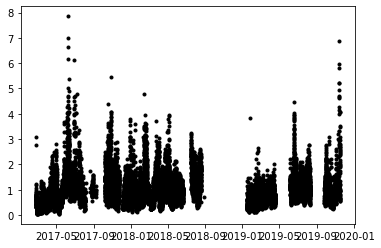

In [8]:
plt.plot(df_sc['dt'],df_sc['flu'],'k.')

In [9]:
# Carregando dados Inmet

inmet = pd.read_csv(os.path.join(datadir,files[1]), header=9, sep=',')
rad_head_list = list(inmet.columns[73:87])
i_dates = []
rad = []

for day in range(53, 1036):
    for header in rad_head_list:
        rad.append(inmet[header][day])
        d = inmet['Unnamed: 0'][day]
        t = str(int(inmet[header][0]))
        if len(t)==1:
            t = "00:0"+t
            date = dt.datetime.strptime("{} {}".format(d,t),'%d-%b-%Y %H:%M')
        elif len(t)==3:
            t = "0"+t[0]+":00"
            date = dt.datetime.strptime("{} {}".format(d,t),'%d-%b-%Y %H:%M')
        elif len(t)== 4:
            t = t[0:2]+":00"
            date = dt.datetime.strptime("{} {}".format(d,t),'%d-%b-%Y %H:%M')
        i_dates.append(date)
            
            
i_dates = pd.Series(i_dates)
df_in=pd.DataFrame({'dt':i_dates,'rad':rad})


df_in = df_in.set_index('dt').reindex(times).fillna(np.nan).rename_axis('dt')
df_in = df_in.reset_index()

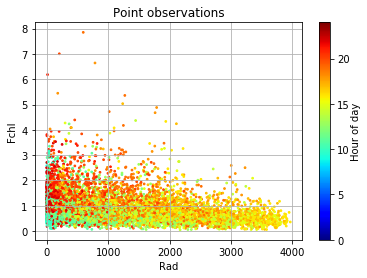

In [193]:
plt.scatter(df_in['rad'],df_sc['flu'],c=times.hour ,vmin=0, vmax=24, cmap="jet",s=3)
plt.grid()
plt.title("Point observations")
plt.xlabel("Rad")
plt.ylabel("Fchl")
cbar= plt.colorbar()
cbar.set_label("Hour of day", labelpad=+1)


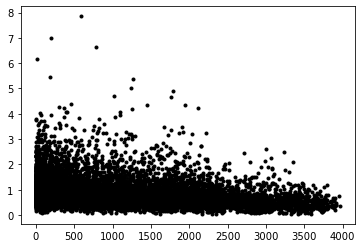

In [10]:
plt.plot(df_in['rad'], df_sc['flu'],'k.')

In [15]:
# calculando os horários de crepusculo com a biblioteca ephem

#criando o observador
boia      = ephem.Observer()

#Localização do observador
boia.lon  = str(-48.42101867)      #Note that lon should be in string format
boia.lat  = str(-27.27445333)      #Note that lat should be in string format

#Elevação do observador em metros
boia.elev = 0

# criando listas vazias para os vetores tempo e fchl para o período noturno
dn_dt = []
dn_flu = []

# laço para cada passo de tempo da série temporal
for h in range(len(df_sc['dt'])):
    bar.update(h) # barra de progresso
    boia.date = df_sc['dt'][h].strftime("%Y-%m-%d") # dia da medição
    sunrise = boia.next_rising(ephem.Sun()) # horário do nascer do sol no dia
    sunset  = boia.next_setting(ephem.Sun()) #horário por do sol no dia
    
    if sunset.datetime()<=df_sc['dt'][h].to_pydatetime(): # seleção para os dados amostrados após o pôr do sol
        dn_dt.append(df_sc['dt'][h]) # adicionando os horários à lista tempo
        dn_flu.append(df_sc['flu'][h]) # adicionando os dados à lista de Fchl
    if sunrise.datetime()>=df_sc['dt'][h].to_pydatetime(): # seleção para os dados amostrados antes do nascer do sol
        dn_dt.append(df_sc['dt'][h]) # adicionando os horários à lista tempo
        dn_flu.append(df_sc['flu'][h]) # adicionando os dados à lista de Fchl 

os.system('cls') # limpando o display de resultados 
dn = pd.DataFrame({'dt':dn_dt,'flu':dn_flu}) # criando pandas  dataframe com os dados noturnos
max_night = dn.groupby(pd.Grouper(key='dt', freq='1D')).agg({'flu':[np.max]}) # agrupando os maiores valores por dia

\ |      #                                        | 23879 Elapsed Time: 0:00:08

In [96]:
ratio = []
for i in range(len(df_sc)):
    bar.update(i)
    for index, row in max_night.iterrows():
        if df_sc['dt'][i].date() == index.date():
            tmp = df_sc['flu'][i]/max_night['flu']['amax'][index]
    ratio.append(tmp)
    os.system('cls')

\ |      #                                        | 23940 Elapsed Time: 3:15:50

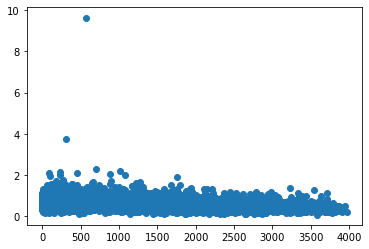

In [111]:
plt.scatter(df_in['rad'],ratio,cmap='viridis')

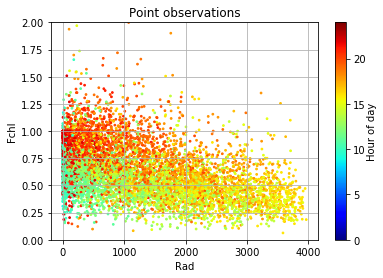

In [209]:
plt.scatter(df_in['rad'],dr['ratio'],c=times.hour ,vmin=0, vmax=24, cmap="jet",s=3)
plt.grid()
plt.title("Point observations")
plt.xlabel("Rad")
plt.ylabel("Fchl")
plt.ylim(0,2)
cbar= plt.colorbar()
cbar.set_label("Hour of day", labelpad=+1)
